# ArbFrVec Extrinsic Evaluation with Google Translate Comparison
This notebook evaluates the ArbFrVec embedding model using a cross-lingual lexical translation task. It also compares retrieval accuracy to Google Translate outputs and visualizes the results.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q --upgrade google-cloud-translate==3.20.2 gensim tqdm regex
!pip install --upgrade pip setuptools wheel
!pip install --upgrade numpy gensim scikit-learn google-cloud-translate matplotlib

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
SHARED = "/content/drive/Shareddrives/CS476"
model_path = f"{SHARED}/randomshuffle_5window_skipgram_300size.model"
cred_path  = f"{SHARED}/natural-potion-459221-v6-3032c41951d7.json"
ar2fr_pkl  = f"{SHARED}/google_ar2fr_single.pkl"
fr2ar_pkl  = f"{SHARED}/google_fr2ar_single.pkl"

In [ ]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import matplotlib.pyplot as plt
from google.cloud import translate_v2 as translate
import os

# Load model and dictionaries
model = Word2Vec.load(model_path)

with open(ar2fr_pkl, "rb") as f:
    ar2fr_data = pickle.load(f)
with open(fr2ar_pkl, "rb") as f:
    fr2ar_data = pickle.load(f)

# Load embedding components
word_to_vec = model.wv
all_words = model.wv.index_to_key
all_vectors = model.wv.vectors

In [ ]:
# Set path to your credentials JSON file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_path
translate_client = translate.Client()

In [ ]:
def evaluate_translation_retrieval(source_dict, direction_label):
    results = {}
    total_evaluated = 0
    top_k_hits = {1: 0, 5: 0, 10: 0}

    for src_word, tgt_list in source_dict.items():
        tgt_word = tgt_list[0]
        if src_word in word_to_vec and tgt_word in word_to_vec:
            total_evaluated += 1
            src_vec = word_to_vec[src_word].reshape(1, -1)
            sims = cosine_similarity(src_vec, all_vectors).flatten()
            top_indices = sims.argsort()[::-1][:10]
            top_words = [all_words[i] for i in top_indices]
            for k in [1, 5, 10]:
                if tgt_word in top_words[:k]:
                    top_k_hits[k] += 1

    for k in [1, 5, 10]:
        precision = round(top_k_hits[k] / total_evaluated, 4) if total_evaluated else 0.0
        results[f"Precision@{k}"] = precision
    results["Total Evaluated"] = total_evaluated
    print(f"{direction_label} → Evaluation Done on {total_evaluated} pairs")
    return results

In [ ]:
def evaluate_google_translate(source_dict, direction="ar2fr"):
    matched = 0
    total = 0
    for src, tgt_list in list(source_dict.items())[:300]:
        try:
            if direction == "ar2fr":
                out = translate_client.translate(src, source_language='ar', target_language='fr')
            else:
                out = translate_client.translate(src, source_language='fr', target_language='ar')
            translated = out["translatedText"].lower().strip()
            expected = tgt_list[0].lower().strip()
            if expected in translated or translated in expected:
                matched += 1
            total += 1
        except Exception as e:
            continue
    return round(matched / total, 4)

In [ ]:
ar2fr_emb = evaluate_translation_retrieval(ar2fr_data, "Arabic to French")
fr2ar_emb = evaluate_translation_retrieval(fr2ar_data, "French to Arabic")

ar2fr_gt = evaluate_google_translate(ar2fr_data, direction="ar2fr")
fr2ar_gt = evaluate_google_translate(fr2ar_data, direction="fr2ar")

print("Google Translate Accuracy:")
print("Arabic to French:", ar2fr_gt)
print("French to Arabic:", fr2ar_gt)

Arabic to French → Evaluation Done on 273 pairs
French to Arabic → Evaluation Done on 63 pairs
Google Translate Accuracy:
Arabic to French: 1.0
French to Arabic: 0.9967


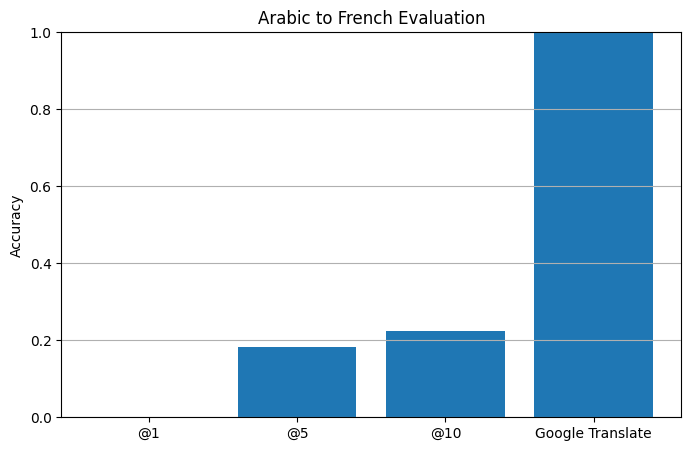

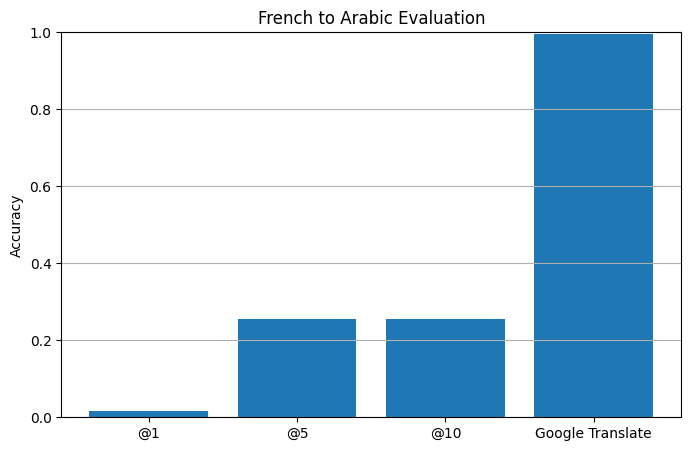

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(embedding_scores, google_score, title):
    labels = ['@1', '@5', '@10', 'Google Translate']
    values = [
        embedding_scores['Precision@1'],
        embedding_scores['Precision@5'],
        embedding_scores['Precision@10'],
        google_score
    ]
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(axis='y')
    plt.show()

plot_comparison(ar2fr_emb, ar2fr_gt, "Arabic to French Evaluation")
plot_comparison(fr2ar_emb, fr2ar_gt, "French to Arabic Evaluation")
